In [364]:
import numpy as np
import pandas as pd
import scanpy as sc
from sklearn.metrics import average_precision_score, auc, precision_recall_curve
from pathlib import Path
from bicycle.utils.mask_utils import get_mask2, get_sparsity
import matplotlib.pyplot as plt
data_path = Path("/data/toulouse/bicycle/notebooks/experiments/masking/data/scMultiSim_data/old_data/")
run_id = "run_04"
data_path /= run_id

In [365]:
def get_precision(grn, beta):
    grn=grn.flatten()
    beta=beta.flatten()
    # normalize to [0, 1]
    grn = (grn > 0).astype(int)
    beta[beta<0] = 0
    beta = beta/np.max(beta)
    average_precision = average_precision_score(grn, beta)
    return average_precision
def get_auprc(grn, beta):
    grn=grn.flatten()
    beta=beta.flatten()
    # normalize to [0, 1]
    grn = (grn > 0).astype(int)
    beta[beta<0] = 0
    beta = beta/np.max(beta)
    p,r,t = precision_recall_curve(grn, beta)
    auprc = auc(r,p)
    return auprc

In [ ]:
atac_base = pd.read_csv(data_path/"processed_atac.csv", index_col=0).to_numpy(np.float32).T
grn = pd.read_csv(data_path/"unperturbed_data"/"geff.csv", index_col=0).to_numpy(np.float32)
region_to_gene = pd.read_csv(data_path/"unperturbed_data"/"region_to_gene.csv", index_col=0).to_numpy(np.float32)
region_to_tf = pd.read_csv(data_path/"unperturbed_data"/"region_to_tf.csv", index_col=0).to_numpy(np.float32)

grn[grn <= 1.0000000e-06] =0

In [367]:
base_data = {"atac":atac_base,
             "region_to_gene":region_to_gene,
             "region_to_tf": region_to_tf,
             }

In [368]:
# Forward selection
def for_select(grn, data, parameters, _baseline_prec = 0, _a=[], _p=[], eval = get_precision):
    if _baseline_prec == 0:
        _p=list()
        _a = list()
        mask = get_mask2(**data, **parameters)
        _baseline_prec = eval(grn, mask)
        print(_baseline_prec)
    precisions = []
    for key, value in parameters.items():

        if value:
            precisions.append(0)
            continue
        if not type(value) is bool:
            precisions.append(0)
            continue
        params = parameters.copy()
        params[key] = True
        mask = get_mask2(**data, **params)
        precisions.append(eval(grn, mask))
    
    print(precisions)
    print(parameters)
    max_prec = np.max(precisions)
    if max_prec <= _baseline_prec:
        plt.subplot(1,2,1)
        plt.plot(_a,_p)
        plt.subplot(1, 2, 2)
        plt.imshow(get_mask2(**data, **parameters))
        return parameters, max_prec
    argmax = np.argmax(precisions)
    maxkey = [n for n in parameters.keys()][argmax]
    parameters[maxkey] = True
    _p.append(max_prec)
    _a.append(maxkey)
    print(_a,_p)
    return for_select(grn, data, parameters, max_prec,_a=_a, _p=_p, eval=eval)
# Reverse selection
def rev_select(grn, data, parameters, _baseline_prec = 0, _a=[], _p=[], eval = get_precision):
    if _baseline_prec == 0:
        _p=list()
        _a = list()
        mask = get_mask2(**data, **parameters)
        _baseline_prec = eval(grn, mask)
        print(_baseline_prec)
    precisions = []
    keys = []
    for key, value in parameters.items():

        if not value:
            continue
        if not type(value) is bool:
            continue
        params = parameters.copy()
        params[key] = False
        mask = get_mask2(**data, **params)
        precisions.append(eval(grn, mask))
        keys.append(key)
    print(f"precisions: {precisions}")
    print(f"keys: {keys}")
    if len(precisions) ==0:
        plt.subplot(1,2,1)
        plt.plot(_a,_p)
        plt.subplot(1, 2, 2)
        plt.imshow(get_mask2(**data, **parameters))
        return parameters
    max_prec = np.max(precisions)
    if max_prec < _baseline_prec:
        plt.subplot(1,2,1)
        plt.plot(_a,_p)
        plt.subplot(1, 2, 2)
        plt.imshow(get_mask2(**data, **parameters))
        return parameters, max_prec
    argmax = np.argmax(precisions)
    maxkey = keys[argmax]
    parameters[maxkey] = False
    _p.append(max_prec)
    _a.append(maxkey)
    print(f"_p: {_p}")
    print(f"_a: {_a}")
    return rev_select(grn, data, parameters, max_prec,_a=_a, _p=_p, eval=eval)


In [369]:
threshold = 80

parameters = {
    "threshold" : True,
    "percentile" : threshold,
    "correlation" : True,
    "corr_normalize" : True,
    "corr_threshold" : True,
    "corr_threshold_percentile" : threshold,
    "pseudocounts" : True,
    }
print(threshold)

80


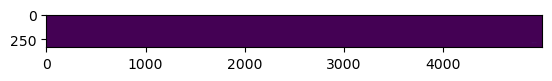

In [370]:
plt.imshow(atac_base)

In [371]:
print(atac_base.sum()/1000000)

3.36704025


0.2629137529137529


precisions: [0.33355835919040383, 0.22354312354312356, 0.2534032634032634, 0.5545810423673019, 0.2629137529137529]
keys: ['threshold', 'correlation', 'corr_normalize', 'corr_threshold', 'pseudocounts']
_p: [0.5545810423673019]
_a: ['corr_threshold']
precisions: [0.7329822365995522, 0.22354312354312356, 0.38315850815850816, 0.5545810423673019]
keys: ['threshold', 'correlation', 'corr_normalize', 'pseudocounts']
_p: [0.5545810423673019, 0.7329822365995522]
_a: ['corr_threshold', 'threshold']
precisions: [0.27220438459355656, 0.5628540084215057, 0.7329822365995522]
keys: ['correlation', 'corr_normalize', 'pseudocounts']
_p: [0.5545810423673019, 0.7329822365995522, 0.7329822365995522]
_a: ['corr_threshold', 'threshold', 'pseudocounts']
precisions: [0.27220438459355656, 0.5628540084215057]
keys: ['correlation', 'corr_normalize']
({'threshold': False, 'percentile': 80, 'correlation': True, 'corr_normalize': True, 'corr_threshold': False, 'corr_threshold_percentile': 80, 'pseudocounts': False

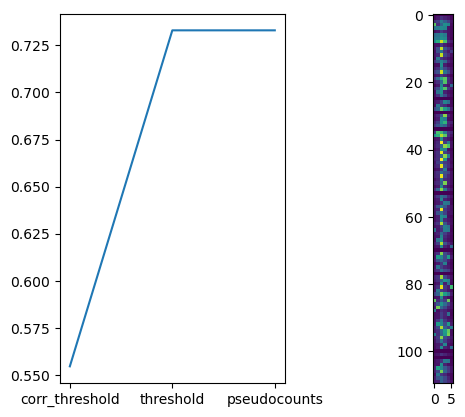

In [372]:
# forward selection
print(rev_select(grn.copy(), base_data.copy(), parameters.copy(),_baseline_prec=0, eval=get_precision))
